# Chapter 3: Orderbooks and Asset Pricing
## Jincheng(Eric) Huang

These exercises are intended to help you use the Kyle model to understand the orderbooks of 5 tickers on a particular day (July 11, 2017). The data have been compiled from the NASDAQ ITCH data files for those days. The data are Python pickle files where each file contains a list of the following form `[(timestamp1,{P1: Q1, P2: Q2, P3:Q3, ...}), (timestamp2, {P1: Q1, P2, Q2, ...})... ]`. That is, the data comes as a list of tuples, where each tuple contains a timestamp and an orderbook. The orderbook is a dictionary where the keys are prices and the values are the quantities available at each price. These data have been compiled in such a way that we have the orderbook every 60 seconds throughtout the trading day.

1. Write a Python class that represents a single orderbook, where the data for that single orderbook is an instance property. Write a method for that orderbook that will use the data to the parameters 𝛾 and 𝛽 from equation (10). Plot the orderbook and the estimated equation. Where does the model fit well and where does it not? Might one want to estimate the model using only a subset of the orderbook? If so, where?

In [1]:
import pickle
import pandas as pd
import numpy as np
import pprint as pprint
import scipy.stats as sts
import matplotlib.pyplot as plt

In [2]:
# Load data
files = ['AAPL', 'C', 'GBX', 'SPY', 'THO']
file_objs = []
for file in files:
    with open('data/' + file, 'rb') as pickle_file:
        file_objs.append(pickle.load(pickle_file))

In [3]:
# Defind a class that represents a single orderbook
class OrderBook:
    """
    This class represents an orderbook. 
    
    Attributes:
        data (dict) : raw data
        time (scalar) : time (in seconds since midnight) of observations
        df (dataframe) : dataframe with price and quantity observations
        P (vector) : vector of prices (with extreme values discarded)
        Q (vector) : vector of quantities (with extreme values discarded)
        midpoint (scalar) : Actual midpoint of the BBO
        gamma (scalar) : intercept of y = gamma + beta * P regression
        beta (scalar) : slope of y = gamma + beta * P regression
        p (scalar) : market clearing price
        ratio (scalar) : noise signal ratio
        
    """
    
    def __init__(self, data, lower, upper):
        """
        Inputs:
            lower (scalar) : lower multiplier for what section of data to use 
                             (relative to market midpoint)
            upper (scalar) : upper multiplier for what section of data to use 
                             (relative to market midpoint)
        
        """
        self.data = data[1]
        self.time = data[0]
        self.lower = lower
        self.upper = upper
        df = pd.DataFrame.from_dict(self.data, orient='index')
    
        # Drop undeed data
        df.columns = ['Quantity', 'Type', 'na','naa']
        df = df.drop(['na', 'naa'], axis = 1)
                
        # Create demand and supply curves
        self.demand = df[df['Type'] == 'B'].sort_index(ascending=False)
        self.supply = df[df['Type'] == 'S'].sort_index()
        self.demand['QD'] = -self.demand['Quantity'].cumsum()
        self.supply['QS'] = self.supply['Quantity'].cumsum()
        
        # Find point where supply = demand
        orders = pd.concat([self.demand, self.supply], sort=True)
        orders = orders.fillna(0)
        orders['Q'] = orders['QD'] + orders['QS']
        self.midpoint = orders[orders.Q < 0].index.values[0]
        
        # Restrict attention to range around equilibrium price
        self.orders = orders[(orders.index > lower * self.midpoint) 
                             & (orders.index < upper * self.midpoint)]
        
        self.Q = self.orders['Q']
        self.P = self.orders.index.values
                
    def estimate(self):
        slope, intercept, r_value, p_value, std_err = sts.linregress(self.P, self.Q)
        self.gamma = intercept
        self.beta = slope
        self.p = - self.gamma/self.beta
        self.ratio = self.beta    

    def plot_orderbook(self, name):
        fig = plt.figure(figsize=(10,7))
        plt.plot(self.demand.index.values, self.demand['QD'], label='Quantity Demanded')
        plt.plot(self.supply.index.values, self.supply['QS'], label='Quantity Supplied')
        p_grid = np.linspace(self.lower * self.midpoint, self.upper * self.midpoint)
        plt.plot(p_grid, self.gamma + self.beta * p_grid, 'r', label='Estimated Equation')
        plt.xlim(0.5 * self.midpoint, 1.5 * self.midpoint)
        plt.xlabel('Price')
        plt.ylabel('Quantity')
        plt.title(name + ' Stock at t = %i' %self.time)
        plt.legend()
        plt.show()
        
    def compare(self):
        print("The estimated p_0 is: %f" %self.p)
        print("The actual midpoint of the BBO is: %f" %self.midpoint)

In [4]:
# A function to plot the order book and the estimated equation
def show_orderbook(file_obj, t, name):
    test = OrderBook(file_obj[t], .9, 1.1)
    test.estimate()
    test.plot_orderbook(name)
    test.compare()

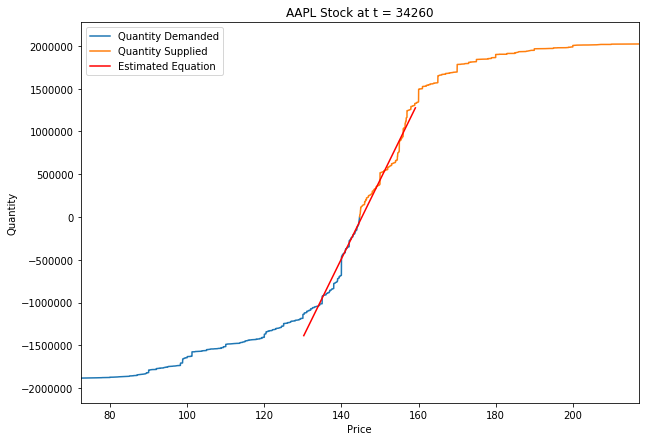

The estimated p_0 is: 145.304897
The actual midpoint of the BBO is: 144.700000


In [20]:
# Show the order book for AAPL stock
show_orderbook(file_objs[0], 0, 'AAPL')

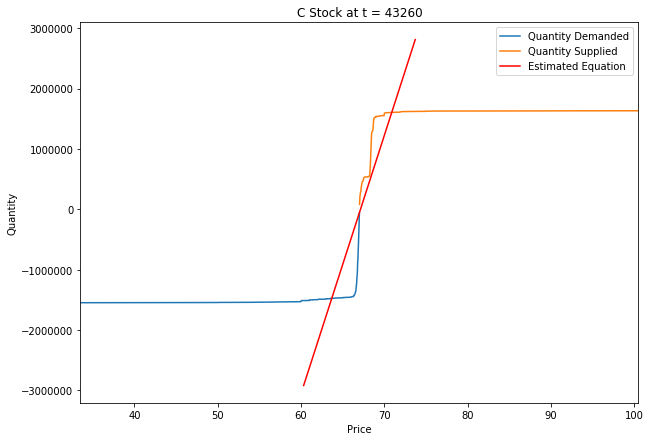

The estimated p_0 is: 67.146500
The actual midpoint of the BBO is: 67.020000


In [26]:
# Show the orderbook for stock C
show_orderbook(file_objs[1], 150, 'C')

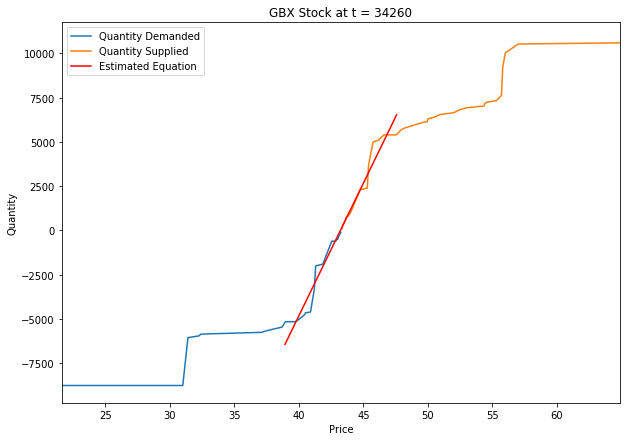

The estimated p_0 is: 43.213939
The actual midpoint of the BBO is: 43.250000


In [28]:
# Show the orderbook for stock GBX
show_orderbook(file_objs[2], 0, 'GBX')

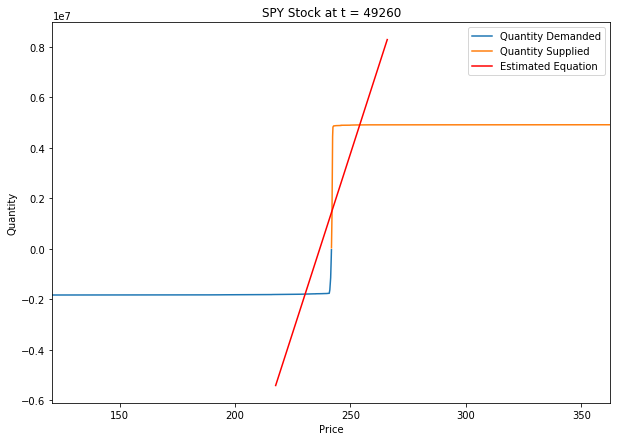

The estimated p_0 is: 236.706842
The actual midpoint of the BBO is: 241.770000


In [33]:
# Show the order book for SPY
show_orderbook(file_objs[3], 250, 'SPY')

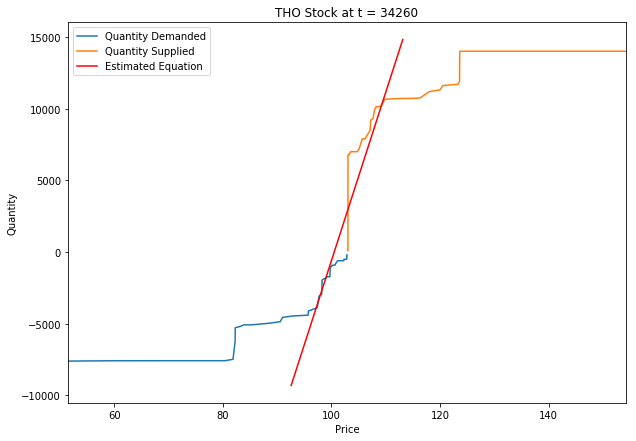

The estimated p_0 is: 100.502674
The actual midpoint of the BBO is: 102.850000


In [39]:
# Show the order book for THO
show_orderbook(file_objs[4], 0, 'THO')

We can see that the linear regression does not fit well when the buy and sell order prices are far from the midpoint. Therefore we should focus on the prices around the midpoint.

2. For each ticker, plot the estimated values of $\frac{2 \sigma_{u}}{\sqrt{\Sigma_{0}}}$ throughout the day.

In [10]:
def plot_coeff(file_obj, title):
    ratio = np.zeros(len(file_obj), dtype=np.float64)
    for idx in range(len(file_obj)):
        book = OrderBook(file_obj[idx], .9, 1.1)
        book.estimate()
        ratio[idx] = book.ratio
    
    fig = plt.figure(figsize=(10,7))
    plt.plot(ratio)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel(r'$\frac{2\sigma_u}{\sqrt{\Sigma_0}}$')
    plt.show()

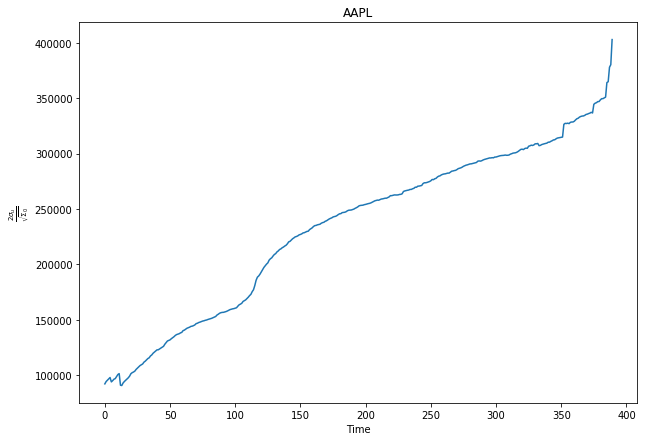

In [11]:
# Plot the slope coefficient of the regression of quantity on price
# AAPL:
plot_coeff(file_objs[0], 'AAPL')

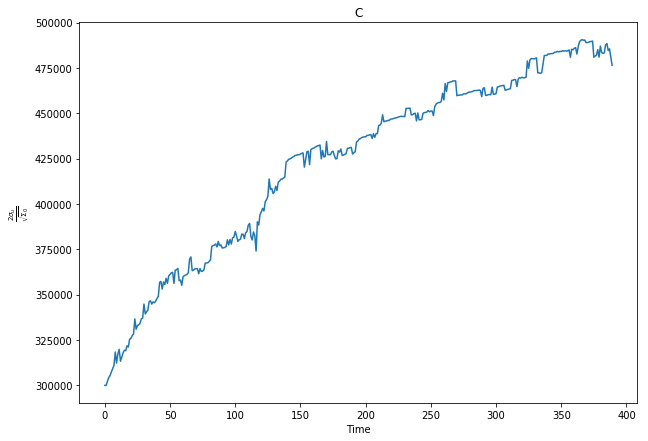

In [12]:
# C:
plot_coeff(file_objs[1], 'C')

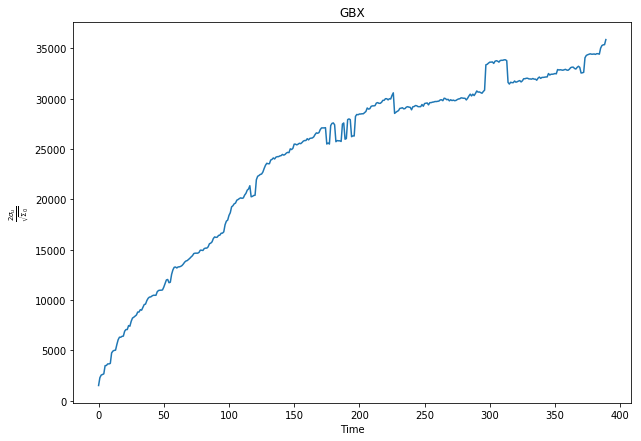

In [13]:
# GBX:
plot_coeff(file_objs[2], 'GBX')

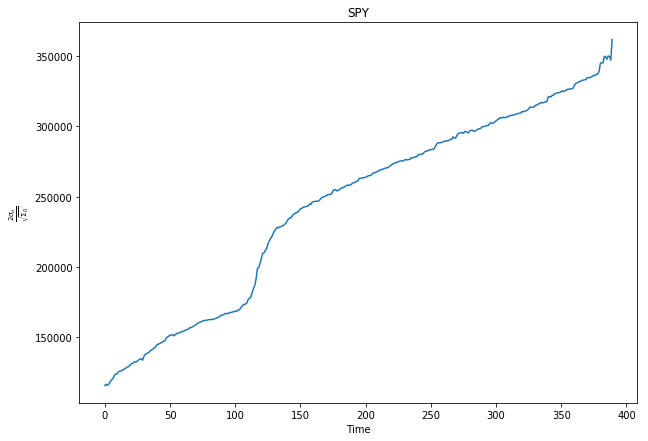

In [14]:
# SPY:
plot_coeff(file_objs[3], 'SPY')

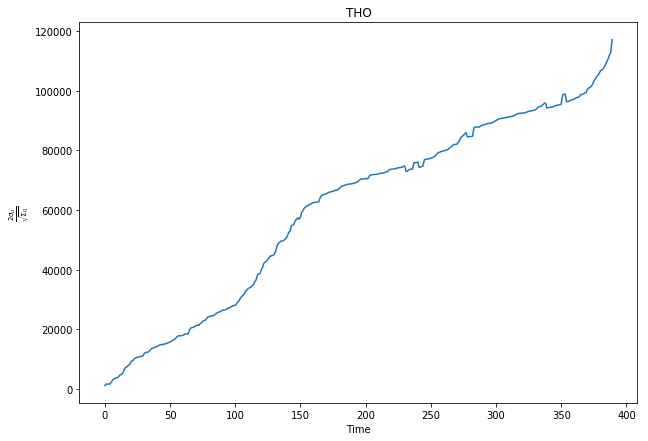

In [16]:
# THO:
plot_coeff(file_objs[4], 'THO')

3. Compare the estimates of $p_0$ to the actual midpoint of the BBO over time. What do these differences say about the nature of the orderbook and the estimation procedure you’re using?

In [17]:
# A function to compare the estimated p0 and actual midpoint p
def compare_p(file_obj,title):
    p_est = np.zeros(len(file_obj), dtype=np.float64)
    p_act = np.zeros(len(file_obj), dtype=np.float64)
    
    for ii in range(len(file_obj)):
        book = OrderBook(file_obj[ii], .9, 1.1)
        book.estimate()
        p_est[ii] = book.p             # estimated p0
        p_act[ii] = book.midpoint      # actual midpoint
        
    fig = plt.figure()
    plt.plot(p_est - p_act, label=r'$\hat{p}_0 - p_0$')
    plt.title(title)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(r'Difference')
    plt.show()
    
    fig = plt.figure()
    plt.plot(p_est, label='Estimated p')
    plt.plot(p_act, label='Actual p')
    plt.title(title)
    plt.legend()
    plt.xlabel('Time')
    plt.ylabel(r'$p$')
    plt.show()

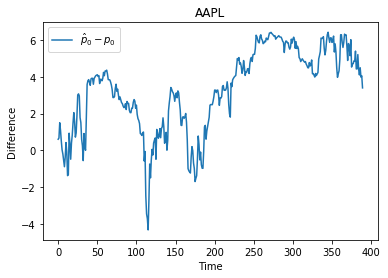

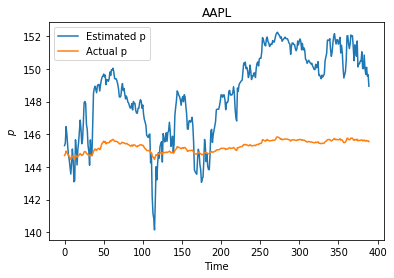

In [18]:
compare_p(file_objs[0], 'AAPL')

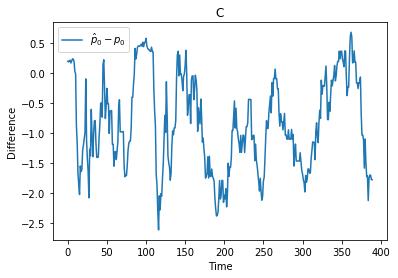

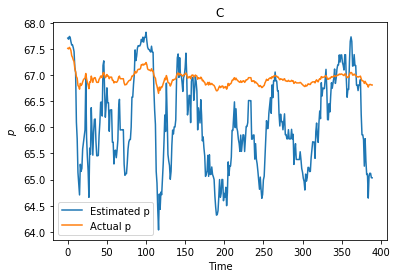

In [40]:
compare_p(file_objs[1], 'C')

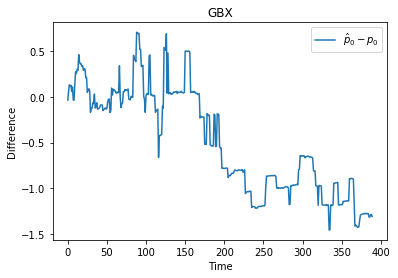

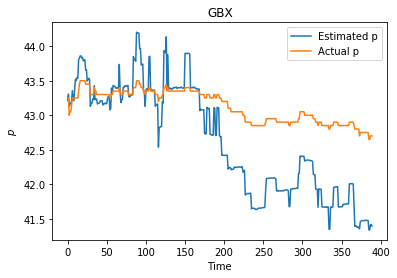

In [41]:
compare_p(file_objs[2], 'GBX')

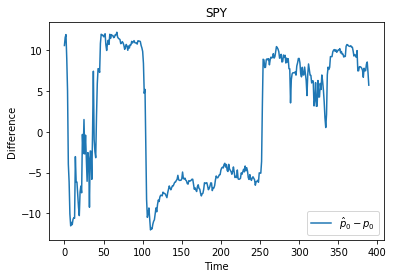

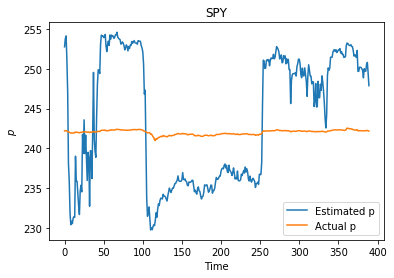

In [42]:
compare_p(file_objs[3], 'SPY')

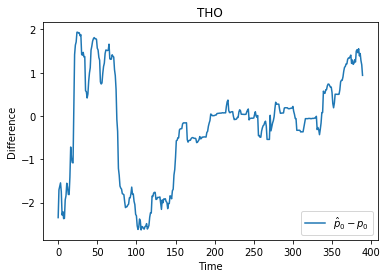

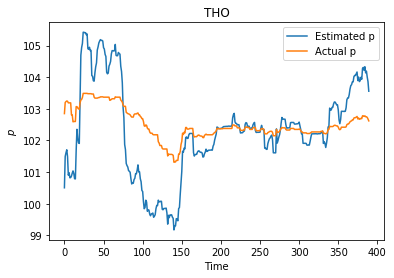

In [43]:
compare_p(file_objs[4], 'THO')

4. Compare/contrast the results for each ticker. Are the noise/signal ratios that you calculate consistent with what you would have expected? What about the movements in $𝑝_0$?

We can see that the prices estimated from Kyle's model are more less volatile than the actual prices. However in some cases the estimated prices do center around the actual ones. This implies that the estimation is very sensitive to changes in buy/sell orders. So although this estimate can be seen as a good approximate at a lower frequency, at a higher frequency the actual prices might have far from the estimated ones.

For noise/signal ratios, I expect them to be higher for tickers that are more volatile, such as 'C'. Indeed, the order book for 'C' is very steep and prices are very volatile. Price estimation also tends to be worse in this case.